In [10]:
%pylab inline
from spectools_ir.utils import extract_hitran_data, spec_convol, make_rotation_diagram
from spectools_ir.flux_calculator import calc_fluxes, make_lineshape
from astropy.io import fits

from spectools_ir.slabspec import make_spec

Populating the interactive namespace from numpy and matplotlib


# Flux_calculator example use

### Read in HITRAN data with extract_hitran_data

In [11]:
hitran_data=extract_hitran_data('CO',4.58,5.2,vup=1)  #Outputs an astropy table

In [12]:
#Read in FITS data containing spectrum.
infile='AATau_M.fits'

hdulist=fits.open(infile)
data=hdulist[1].data
wave=data['WAVELENGTH'][0]*1e-3
flux=data['FLUX'][0]

Text(0, 0.5, 'Flux [Jy]')

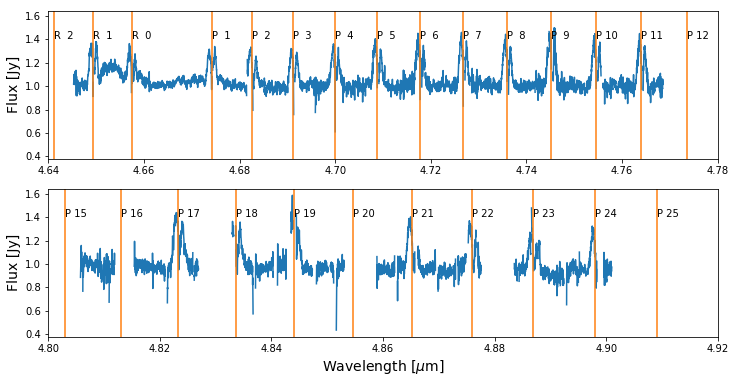

In [13]:
#Plot spectrum.
fig=plt.figure(figsize=(12,6))

ax1=fig.add_subplot(211)
ax1.plot(wave,flux)
ax1.set_xlim(4.64,4.78)
for i,mywave in enumerate(hitran_data['wave']):
    if( (mywave>4.64) & (mywave<4.78) ):
        ax1.axvline(mywave,color='C1')
        ax1.text(hitran_data['wave'][i],1.4,hitran_data['Qpp'][i].strip())
ax1.set_ylabel('Flux [Jy]',fontsize=14)

ax2=fig.add_subplot(212)
ax2.plot(wave,flux)
ax2.set_xlim(4.8,4.92)
for i,mywave in enumerate(hitran_data['wave']):
    if( (mywave>4.8) & (mywave<4.92) ):
        ax2.axvline(mywave,color='C1')
        ax2.text(hitran_data['wave'][i],1.4,hitran_data['Qpp'][i].strip())
ax2.set_xlabel('Wavelength [$\mu$m]',fontsize=14)
ax2.set_ylabel('Flux [Jy]',fontsize=14)

### Calculate line fluxes for dataset, using locations specified in hitran dataset

Not enough data near  5.188746452331543  microns. Skipping.
Not enough data near  5.174523830413818  microns. Skipping.
Not enough data near  5.160454273223877  microns. Skipping.
Not enough data near  5.146536350250244  microns. Skipping.
Not enough data near  5.132768630981445  microns. Skipping.
Not enough data near  5.119149684906006  microns. Skipping.
Not enough data near  5.105678558349609  microns. Skipping.
Not enough data near  5.092352867126465  microns. Skipping.
Not enough data near  5.079172134399414  microns. Skipping.
Not enough data near  5.066134452819824  microns. Skipping.
Not enough data near  5.053239345550537  microns. Skipping.
Not enough data near  5.040484428405762  microns. Skipping.
Not enough data near  5.02786922454834  microns. Skipping.
Not enough data near  5.015391826629639  microns. Skipping.
Not enough data near  5.003051280975342  microns. Skipping.
Not enough data near  4.990846633911133  microns. Skipping.
Not enough data near  4.978776931762695  

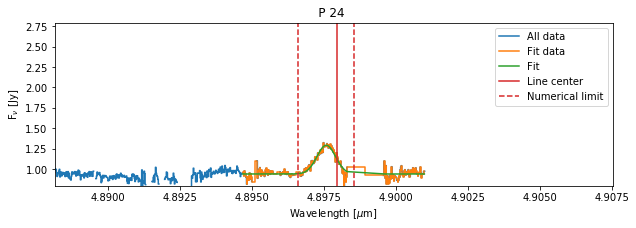

Is this fit okay? [y or n]y


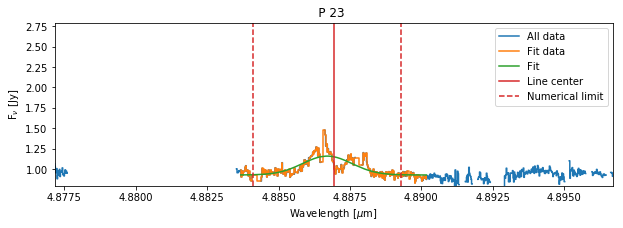

Is this fit okay? [y or n]y


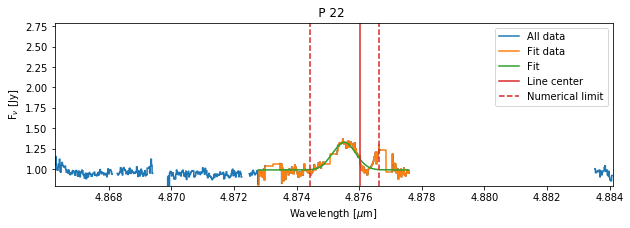

Is this fit okay? [y or n]y


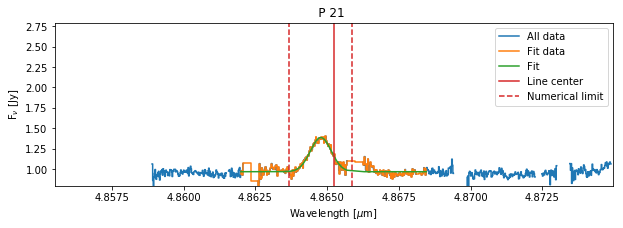

Is this fit okay? [y or n]y


/Users/cosalyk/mypy/spectools_ir/flux_calculator/helpers.py:187: RuntimeWarning: Mean of empty slice
  dwave=np.nanmean(np.diff(myx[mybool]))


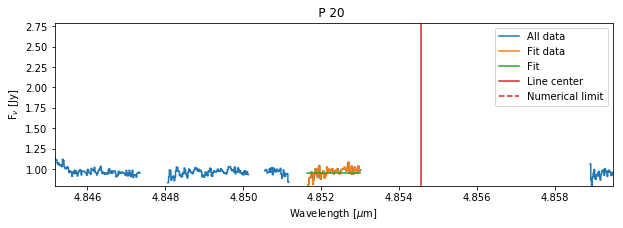

Is this fit okay? [y or n]y


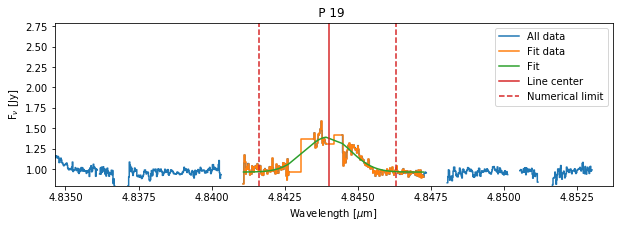

Is this fit okay? [y or n]y
Error - curve_fit failed


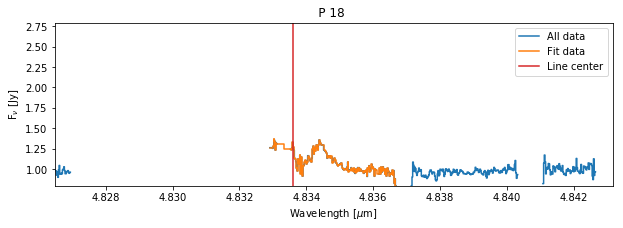

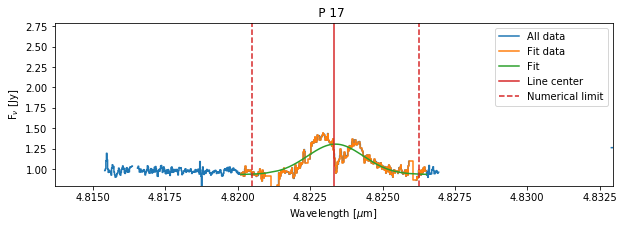

Is this fit okay? [y or n]y


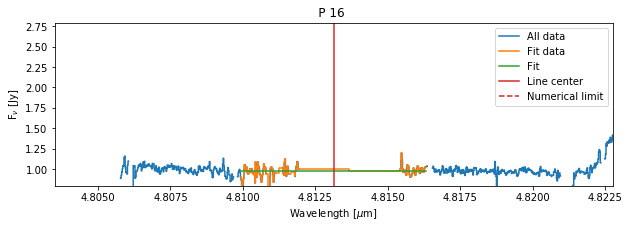

Is this fit okay? [y or n]n


/Users/cosalyk/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


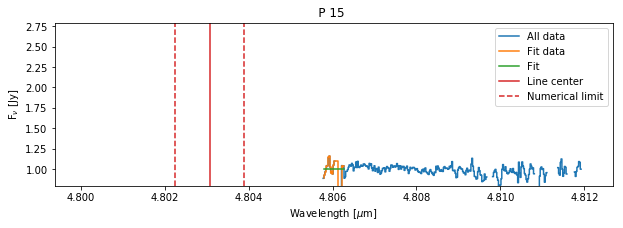

Is this fit okay? [y or n]n
Not enough data near  4.793123722076416  microns. Skipping.
Not enough data near  4.78329610824585  microns. Skipping.
Not enough data near  4.77358341217041  microns. Skipping.


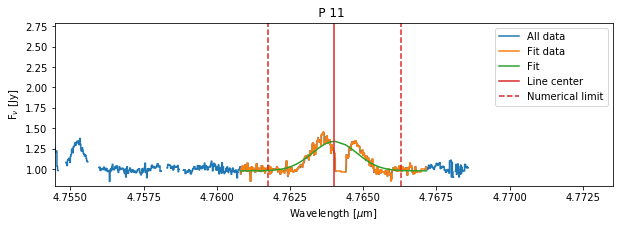

Is this fit okay? [y or n]y


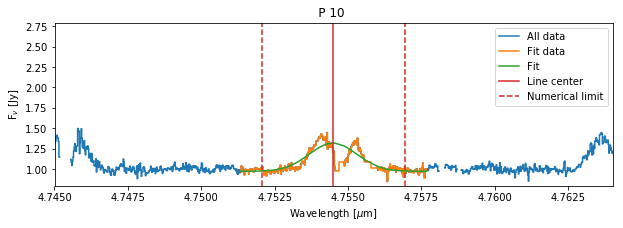

Is this fit okay? [y or n]y


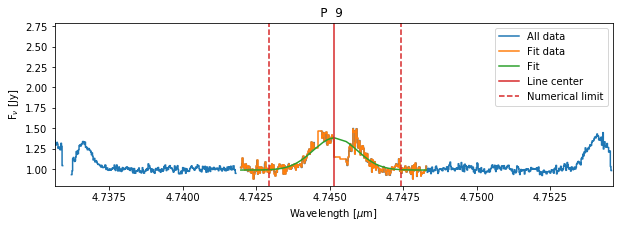

Is this fit okay? [y or n]y


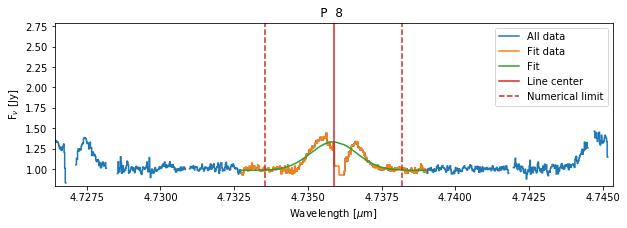

Is this fit okay? [y or n]y


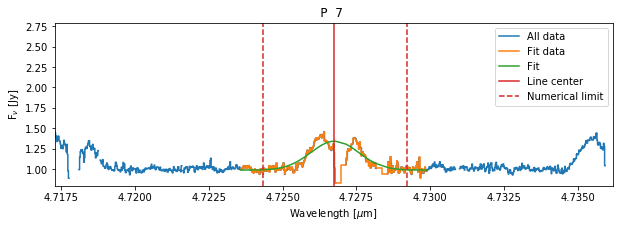

Is this fit okay? [y or n]y


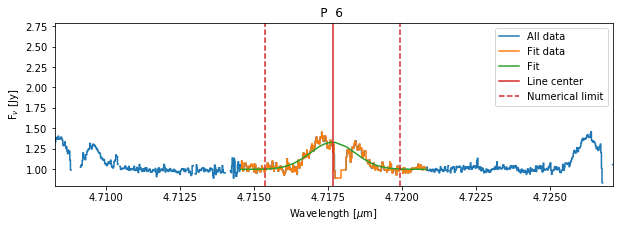

Is this fit okay? [y or n]y


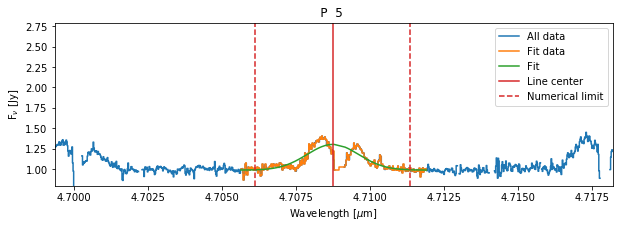

Is this fit okay? [y or n]y


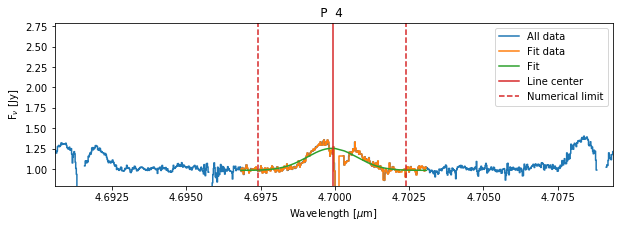

Is this fit okay? [y or n]y


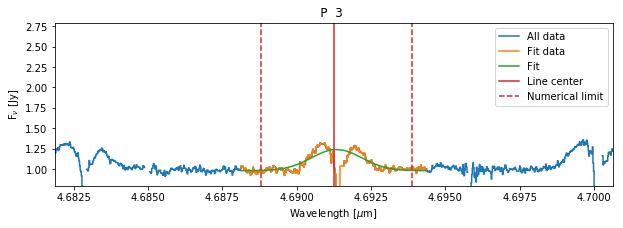

Is this fit okay? [y or n]y


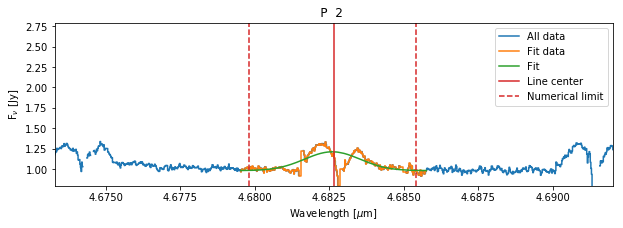

Is this fit okay? [y or n]y


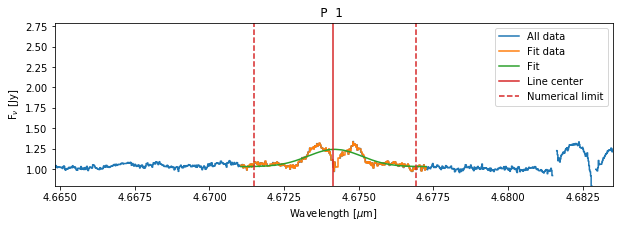

Is this fit okay? [y or n]y


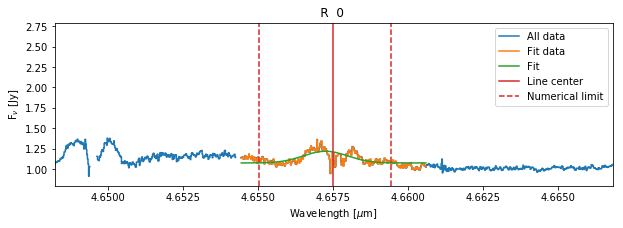

Is this fit okay? [y or n]y


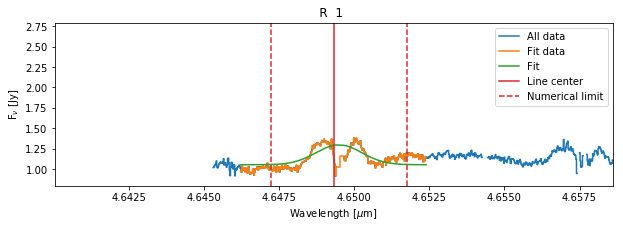

Is this fit okay? [y or n]y
Not enough data near  4.641242027282715  microns. Skipping.
Not enough data near  4.633276462554932  microns. Skipping.
Not enough data near  4.625414848327637  microns. Skipping.
Not enough data near  4.6176557540893555  microns. Skipping.
Not enough data near  4.60999870300293  microns. Skipping.
Not enough data near  4.602443695068359  microns. Skipping.
Not enough data near  4.594989776611328  microns. Skipping.
Not enough data near  4.5876359939575195  microns. Skipping.
Not enough data near  4.580382347106934  microns. Skipping.


In [14]:
#Calculate fluxes.
lineflux_data=calc_fluxes(wave,flux,hitran_data, v_dop=0,fwhm_v=40.,sep_v=200.,cont=1.05,vet_fits=True, plot=True)

### Create a composite lineshape using info from flux_calculator output

In [15]:
lineshape_data=make_lineshape(wave,flux,lineflux_data)

Text(0, 0.5, 'Arbitrary flux')

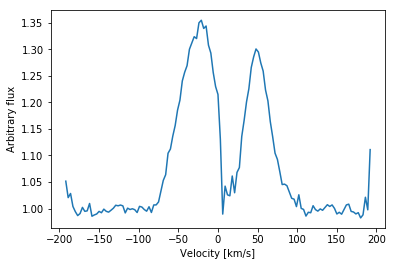

In [16]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(lineshape_data[0],lineshape_data[1])
ax1.set_xlabel('Velocity [km/s]')
ax1.set_ylabel('Arbitrary flux')

/Users/cosalyk/mypy/spectools_ir/utils/utils.py:31: RuntimeWarning: divide by zero encountered in log
  y=np.log(lineparams['lineflux']/(lineparams['wn']*1e2*gup*lineparams['a']))   #All mks


Text(0, 0.5, 'ln(F/(gA$\\tilde{\\nu}$))')

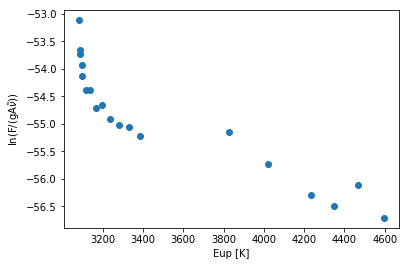

In [17]:
rot=make_rotation_diagram(lineflux_data)

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(rot['x'],rot['y'],'C0o')
ax1.set_xlabel('Eup [K]')
ax1.set_ylabel(r'ln(F/(gA$\tilde{\nu}$))')

# Slabspec example use

### Make a slab model spectrum with make_spec

In [56]:
au=1.5e11
model_output=make_spec('CO',1e22,1000,np.pi*(0.3*au)**2., wmin=4.58,wmax=5.2,convol_fwhm=30.,d_pc=140.,res=1e-5)

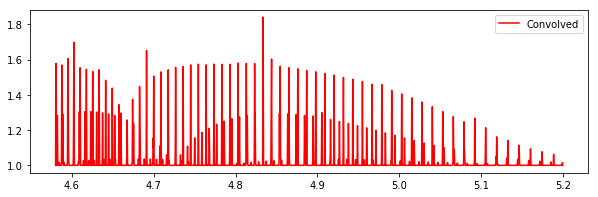

In [57]:
fig=plt.figure(figsize=(10,3))
ax1=fig.add_subplot(111)
#ax1.plot(model_output['spectrum']['wave'],model_output['spectrum']['flux']+1,label='Not convolved')
ax1.plot(model_output['spectrum']['wave'],model_output['spectrum']['convolflux']+1,'r',label='Convolved')
ax1.legend()

### Output model fluxes as a rotation diagram (compare to data if desired)

In [53]:
rd_model=make_rotation_diagram(model_output['lineparams'])
rd_data=make_rotation_diagram(lineflux_data)

/Users/cosalyk/mypy/spectools_ir/utils/utils.py:31: RuntimeWarning: divide by zero encountered in log
  y=np.log(lineparams['lineflux']/(lineparams['wn']*1e2*gup*lineparams['a']))   #All mks


(-57, -52.5)

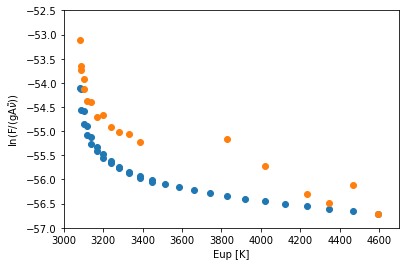

In [61]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(rd_model['x'],rd_model['y'],' C0o',label='Model')
ax1.plot(rd_data['x'],rd_data['y'],' C1o',label='Data')
ax1.set_xlabel('Eup [K]')
ax1.set_ylabel(r'ln(F/(gA$\tilde{\nu}$))')
ax1.set_xlim(3000,4700)
ax1.set_ylim(-57,-52.5)

# Slab_fitter example use

In [ ]:
#To do:
#Compile and demonstrate other useful routines
#Test slab_fitter